<a href="https://colab.research.google.com/github/GKS07/Computer_Vision/blob/main/Image_Captioning(Flicker_8K).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captionning

Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.<br>I will use Xception pretrained model to extract the features from the image and then i'll feed the features into LSTM to generate the discription of the image.


**Connecting to the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing the Libraries**

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow
import os
import pickle
from textwrap import wrap
import re

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, add
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# changing the working directory
os.chdir("/content/drive/MyDrive")

In [3]:
#getting the current directory
os.getcwd()

'/content/drive/MyDrive'

**Downloading the data from Kaggle**

In [ ]:
from google.colab import files
files.upload()

# copying the kaggle file

!mkdir ~/.kaggle # nmaking the folder

! cp kaggle.json ~/.kaggle/  #copy the file

#changing the permission.
! chmod 600 ~/.kaggle/kaggle.json


# downloading the data from kaggle

!kaggle datasets download -d adityajn105/flickr8k
# making the folder
!mkdir Image_Captioning

Saving kaggle.json to kaggle.json
100% 1.04G/1.04G [00:19<00:00, 30.3MB/s]
100% 1.04G/1.04G [00:19<00:00, 58.0MB/s]


In [ ]:
#unzipping the data

!unzip flickr8k.zip -d Image_Captioning

# Preprocessing the data

In [4]:
img_path = '/content/drive/MyDrive/Image_Captioning/Images'

In [ ]:
# defining the functon foe displaying the images

def display_images(image):
  subplot = 231
  plt.figure(figsize = (10,6))
  for j in range(len(image)):
    disp_img(image[j], 231 + j)

  plt.tight_layout()
  plt.subplots_adjust(wspace = 0.1, hspace = 0.1)
  plt.show()



def disp_img(image, subplot):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)

In [ ]:
# function for extracting images from file
images = []
def images_in_file(img_path):
  for file in tqdm(os.listdir(img_path)[:6]):
    img_file = os.path.join(img_path,file)
    image = cv.imread(img_file)
    resize_image = cv.resize(image, (220,220), interpolation = cv.INTER_LINEAR)
    images.append(resize_image)

  return  images

  0%|          | 0/6 [00:00<?, ?it/s]

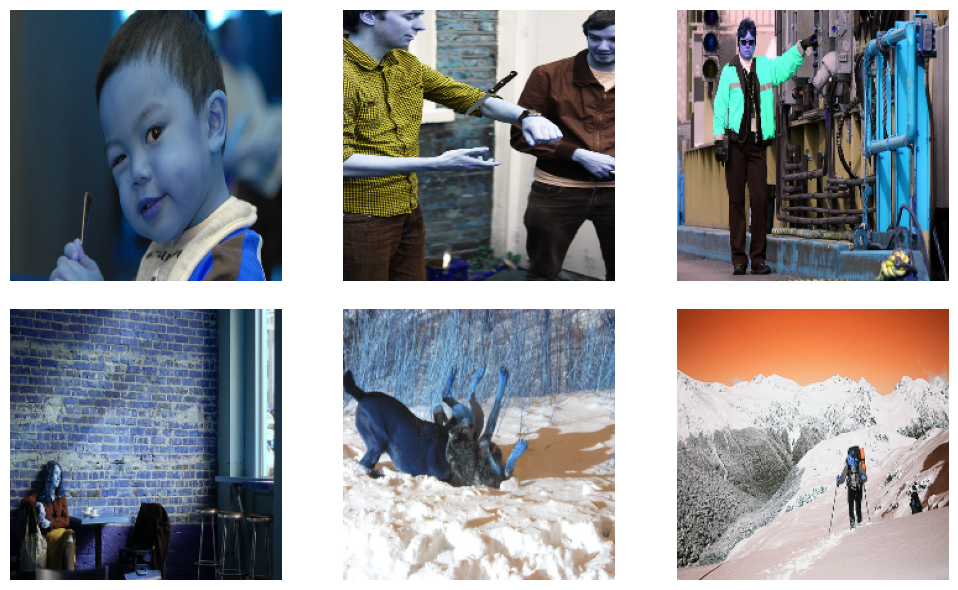

In [ ]:
with tf.device('/device:GPU:0'):
  images_array = images_in_file(img_path)
  display_images(images_array)

**Extracting the Image Features using Xception**

In [ ]:
# Loading the EfficientNetB3 model

model = EfficientNetB3(include_top = False, weights = 'imagenet', pooling = 'max')

mdoel = Model(inputs=model.inputs, outputs=model.layers[-1].output)

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [ ]:
# Extracting the features of image and loading it to a dictionary

features = {}
def feature_extractor(image_path):
  for file_name in tqdm(os.listdir(image_path)):
    img_file = os.path.join(img_path,file_name)
    image = cv.imread(img_file)
    image = cv.resize(image, (300,300), interpolation = cv.INTER_LINEAR) # resizing the images.
    image = preprocess_input(image)# preprocessing the image for pretrained model.
    feature = model.predict(image, verbose = 0) # extracting the image feature, verbose = 0 it will not print any output.
    image_id = file_name.split('.')[0] #splitting the name to make a image id.
    features[image_id] = feature #storing the features into dictionary.




In [ ]:
feature_extractor(img_path)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
print(len(features))

8091


In [ ]:
#storing the features in pickle file.

pickle.dump(features, open(os.path.join('/content/drive/MyDrive/Image_Captioning', 'features.pkl'), 'wb'))

In [5]:
# loading the pickle file.

with open(os.path.join('/content/drive/MyDrive/Image_Captioning', 'features.pkl'), 'rb') as file:
    features = pickle.load(file)

In [6]:
# loading the caption file

data = pd.read_csv('/content/drive/MyDrive/Image_Captioning/captions.txt')

In [ ]:
data.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [7]:
# creating a list of unique images from data.image
unique_images = data['image'].unique().tolist()

In [8]:
total_images =  len(unique_images)
print("The total number of the images is:", total_images)

The total number of the images is: 8091


In [ ]:
print("The number of captions we have:",len(data.caption))

The number of captions we have: 40455


In [36]:
#Displaying Images with Caption..

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 25))
    n = 0
    for i in tqdm(range(15)):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.2, wspace = 0.3)
        image = cv.imread(f"{img_path}/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20))) # Wraps the single paragraph in text (a string) so every line is at most width characters long.
        plt.axis("off")

  0%|          | 0/15 [00:00<?, ?it/s]

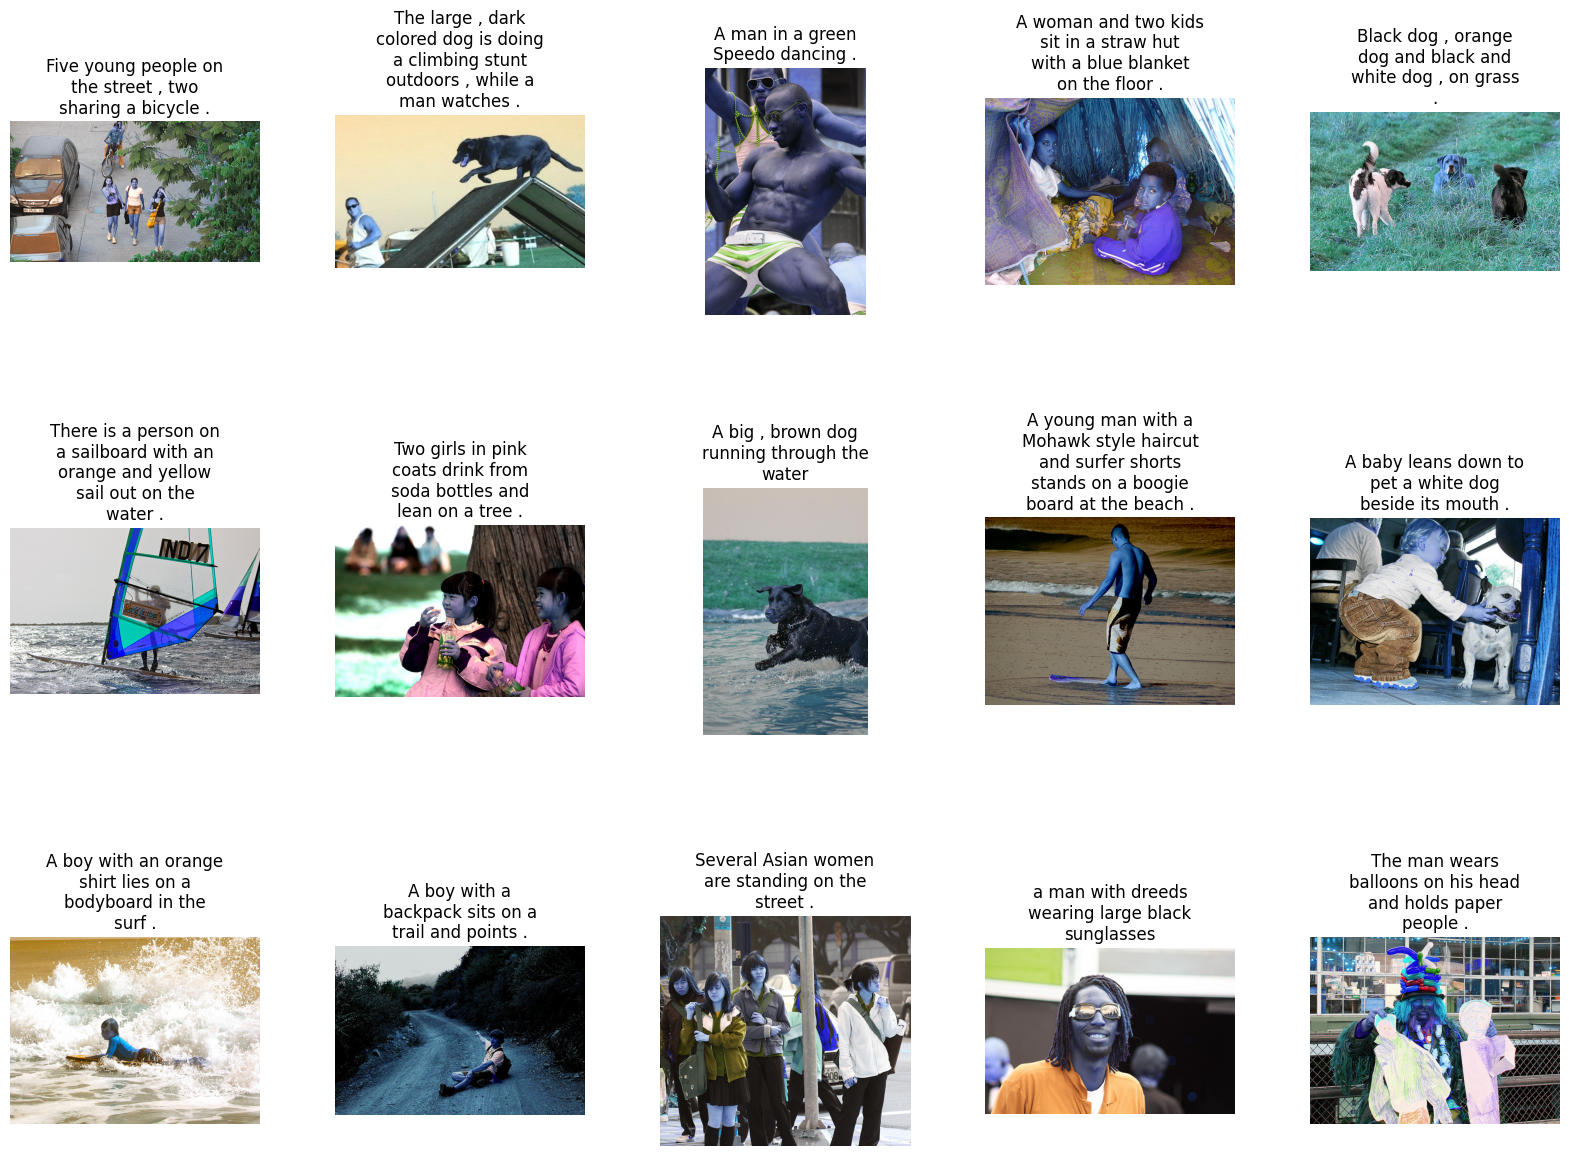

In [ ]:
display_images(data.sample(15))

**Caption Preprocessing**

In [9]:
def caption_preprocessin(data_frame):
  data['caption'] = data['caption'].apply(lambda x: x.lower()) # lowering the words.
  data['caption'] = data['caption'].apply(lambda x: re.sub("[^A-Za-z]", " ", x))# removing the special characters
  #data['caption'] = data['caption'].apply(lambda x: re.sub("\s+", " ", x)) # removing the extra spaces
  data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1])) #removing the single word
  data['caption'] = "startseq " + data['caption'] + " endseq" # adding the start and end to the caption.
  return data_frame

In [10]:
data = caption_preprocessin(data)
processed_caption = data['caption'].tolist()
processed_caption[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
data.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...
5,1001773457_577c3a7d70.jpg,startseq black dog and spotted dog are fightin...
6,1001773457_577c3a7d70.jpg,startseq black dog and tri colored dog playing...
7,1001773457_577c3a7d70.jpg,startseq black dog and white dog with brown sp...
8,1001773457_577c3a7d70.jpg,startseq two dogs of different breeds looking ...
9,1001773457_577c3a7d70.jpg,startseq two dogs on pavement moving toward ea...


**Tokenizing the caption**

In [ ]:
token = Tokenizer()
token.fit_on_texts(processed_caption)
vocab_size = len(token.word_index) + 1

In [ ]:
vocab_size

8427

In [17]:
#maximum length of the caption we have

max_length = max(len(caption.split()) for caption in processed_caption)
max_length

35

In [22]:
#mapping the captions to their images as image_id

map = {}

for i in tqdm(range(len(data))):
  image_id, caption = data.image[i].split('.')[0], data.caption[i]

  if image_id not in map:
    map[image_id] = []

  map[image_id].append(caption)



  0%|          | 0/40455 [00:00<?, ?it/s]

In [ ]:
map['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

**Splitting the data into Trian and Test.**

In [18]:
split_images = round(0.90*total_images)

train_images = unique_images[:split_images] # will be using this as image id
test_images = unique_images[split_images:] # same for this

train_data = data[data['image'].isin(train_images)]
test_data = data[data['image'].isin(test_images)]

train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)


In [ ]:
#sample of the tokenize text to integer

token.texts_to_sequences([processed_caption[3]])[0] # it will convert the text to integers

[1, 39, 18, 118, 4, 391, 19, 59, 2425, 2]

**Generating Data**

In [ ]:
 # we will fetch data in batch to the model to avoid the session crash.
def data_generator(df, map, features, tokenizer, max_length, vocab_size, batch_size):
  # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
      for key in df.image:
        n += 1
        key = key.split('.')[0]
        captions = map[key]
        # process each caption
        for caption in captions:
          # encode the sequence
          seq = tokenizer.texts_to_sequences([caption])[0]
          # split the sequence into X, y pairs
          for i in range(1, len(seq)):
            # split into input and output pairs
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store the sequences
            X1.append(features[key][0])
            X2.append(in_seq)
            y.append(out_seq)
        if n == batch_size:
          X1, X2, y = np.array(X1), np.array(X2), np.array(y)
          #yield [X1, X2], y
          return X1.shape, X2.shape#, len(y)
          X1, X2, y = list(), list(), list()
          n = 0

In [ ]:
train_data[:1]

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...


# **Defining the model**

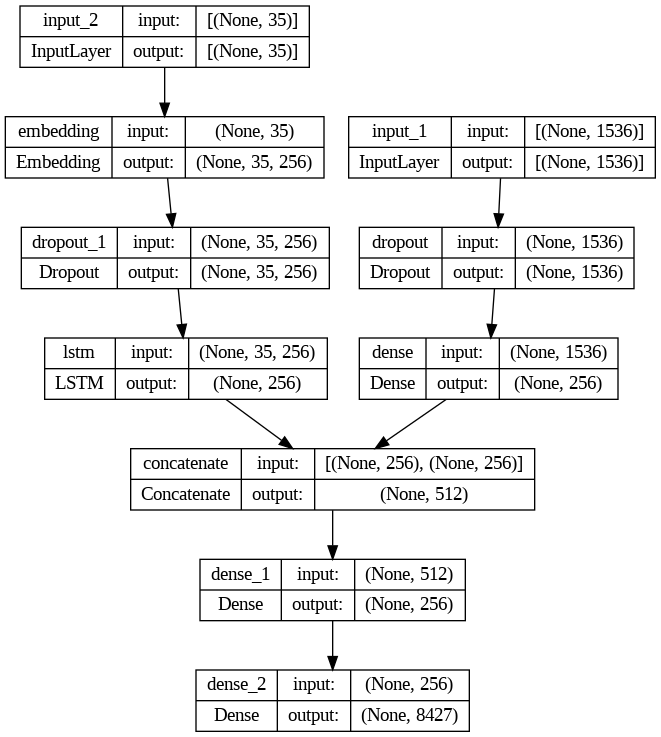

In [ ]:
# encoder model

# image layers
input1 = Input(shape=(1536,))
drop1 = Dropout(0.3)(input1)
fc1 = Dense(256, activation='relu')(drop1)

# text  layers
input2 = Input(shape=(max_length,))
embedding = Embedding(vocab_size, 256, mask_zero=True)(input2)
drop2 = Dropout(0.3)(embedding)
lstm = LSTM(256)(drop2)

# decoder model
decoder1 = concatenate([fc1, lstm], axis = 1)
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

**Training the model**

In [ ]:
#checkpoints and early stopping

model_name = "image_captionong_flicker8K.h5"

checkpoint = ModelCheckpoint(model_name,
                            monitor = "loss",
                            mode = "min",
                            save_best_only = True,
                            verbose = 1
                             )

earlystopping = EarlyStopping(monitor = 'loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True
                              )

learning_rate_reduction = ReduceLROnPlateau(monitor = 'loss',
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.3,
                                            min_lr = 0.000001)

In [ ]:
epochs = 15
batch_size = 28
steps = len(train_data) // batch_size
with tf.device('/device:GPU:0'):
  for i in range(epochs):
    train_generator = data_generator(train_data, map, features, token, max_length, vocab_size, batch_size) #generating the data
    #print("epoch =", i)
    #test_generator = data_generator(test_data, map, features, token, max_length, vocab_size, batch_size)
    model.fit(train_generator, epochs = 1, steps_per_epoch = steps, verbose = 1)

1300/1300 [==============================] - 286s 220ms/step - loss: 1.9801


In [ ]:
#saVING THE MODEL

model.save('/content/drive/MyDrive/Image_Captioning'+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# loading teh model

my_model = tf.keras.models.load_model('/content/drive/MyDrive/Image_Captioning/best_model.h5')

# **Genearating the Captions**

In [13]:
def word_generator(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
  return None

In [50]:
def predict_caption(model, image, tokenizer, max_length, features):

    image = image.split('.')[0]
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = word_generator(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [33]:
sample = test_data.sample(15)
sample.reset_index(drop = True, inplace = True)
#print(sample)

In [51]:
for index,record in tqdm(sample.iterrows()):

    img = cv.imread(os.path.join(img_path,record['image']))
    #img = img_to_array(img)
    img = img/255.

    caption = predict_caption(my_model, record['image'], token, max_length, features)
    sample.loc[index,'caption'] = caption

0it [00:00, ?it/s]

ValueError: Data cardinality is ambiguous:
  x sizes: 10, 1
Make sure all arrays contain the same number of samples.

In [46]:
img = test_data.image[1]
img = img.split('.')[0]
print(img)

436393371_822ee70952
